In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Using: cuda
Classes: ['0', '1', '2', '3', '4', '5', '6']

Starting Fold 1
[Fold 1] Epoch 1/10 | Train=1.308 | Val=1.141 | Acc=51.71%
[Fold 1] Epoch 2/10 | Train=0.665 | Val=1.025 | Acc=56.59%
[Fold 1] Epoch 3/10 | Train=0.306 | Val=1.173 | Acc=55.61%
[Fold 1] Epoch 4/10 | Train=0.158 | Val=1.227 | Acc=58.54%
[Fold 1] Epoch 5/10 | Train=0.098 | Val=1.286 | Acc=55.12%
[Fold 1] Epoch 6/10 | Train=0.070 | Val=1.400 | Acc=54.63%
[Fold 1] Epoch 7/10 | Train=0.050 | Val=1.318 | Acc=58.05%
[Fold 1] Epoch 8/10 | Train=0.035 | Val=1.362 | Acc=54.15%
Early stopping triggered!

Starting Fold 2
[Fold 2] Epoch 1/10 | Train=1.307 | Val=1.498 | Acc=52.94%
[Fold 2] Epoch 2/10 | Train=0.719 | Val=1.522 | Acc=57.35%
[Fold 2] Epoch 3/10 | Train=0.331 | Val=1.809 | Acc=57.84%
[Fold 2] Epoch 4/10 | Train=0.168 | Val=1.981 | Acc=55.88%
[Fold 2] Epoch 5/10 | Train=0.088 | Val=1.913 | Acc=58.82%
[Fold 2] Epoch 6/10 | Train=0.062 | Val=2.036 | Acc=58.33%
[Fold 2] Epoch 7/10 | Train=0.048 | Val=2.046 | Acc=54.41

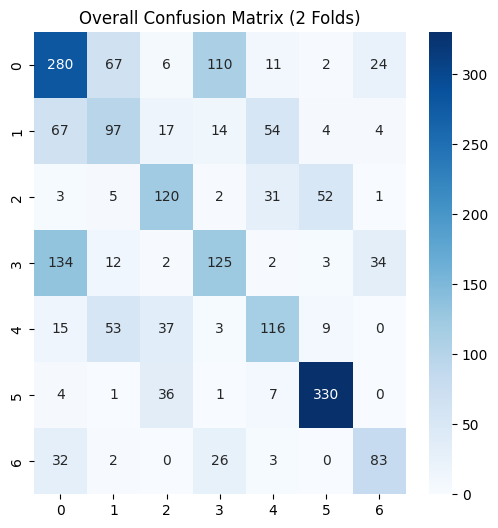


Saved all metrics CSVs and plots!


In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, models, transforms
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, accuracy_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import os

# ================================================================
# DEVICE SETUP
# ================================================================

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using:", device)

# ================================================================
# SAFE IMAGE LOADER
# ================================================================

class SafeImageFolder(datasets.ImageFolder):
    def __getitem__(self, index):
        try:
            return super().__getitem__(index)
        except Exception:
            bad = self.imgs[index][0]
            print(f"Skipped corrupted image: {bad}")
            dummy = Image.new("RGB", (224, 224))
            if self.transform:
                dummy = self.transform(dummy)
            return dummy, 0

# ================================================================
# DATA PATH
# ================================================================

data_dir = "/content/drive/MyDrive/split_dataset_1-20251204T224240Z-3-001/split_dataset_1/train"

# ================================================================
# TRANSFORMS: augmentation + normalization
# ================================================================

imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std = [0.229, 0.224, 0.225]

train_tf = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
    transforms.ToTensor(),
    transforms.Normalize(imagenet_mean, imagenet_std)
])

val_tf = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(imagenet_mean, imagenet_std)
])

# ================================================================
# LOAD DATASET
# ================================================================

full_dataset = SafeImageFolder(data_dir, transform=train_tf)
y = [label for _, label in full_dataset.imgs]
num_classes = len(full_dataset.classes)
print("Classes:", full_dataset.classes)

# ================================================================
# CREATE MODEL
# ================================================================

def create_model():
    model = models.resnet50(weights="IMAGENET1K_V2")

    # Freeze backbone
    for param in model.parameters():
        param.requires_grad = False

    # Unfreeze last block for fine-tuning
    for param in model.layer4.parameters():
        param.requires_grad = True

    # Better classifier head
    model.fc = nn.Sequential(
        nn.Linear(model.fc.in_features, 512),
        nn.BatchNorm1d(512),
        nn.ReLU(),
        nn.Dropout(0.4),
        nn.Linear(512, num_classes)
    )

    return model.to(device)

# ================================================================
# TRAIN ONE FOLD
# ================================================================

def train_one_fold(model, train_loader, val_loader, fold, class_weights=None, epochs=20):
    criterion = nn.CrossEntropyLoss(weight=class_weights)
    optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=3e-4)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=2, factor=0.5)

    best_acc = 0
    patience = 4
    wait = 0

    history = {"epoch": [], "train_loss": [], "val_loss": [], "val_acc": []}

    for epoch in range(epochs):
        model.train()
        train_loss = 0

        for imgs, labels in train_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            optimizer.zero_grad()

            outputs = model(imgs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        train_loss /= len(train_loader)

        # Validation
        model.eval()
        val_loss = 0
        y_true, y_pred = [], []

        with torch.no_grad():
            for imgs, labels in val_loader:
                imgs, labels = imgs.to(device), labels.to(device)
                outputs = model(imgs)

                loss = criterion(outputs, labels)
                val_loss += loss.item()

                preds = outputs.argmax(1)
                y_true.extend(labels.cpu().numpy())
                y_pred.extend(preds.cpu().numpy())

        val_loss /= len(val_loader)
        val_acc = accuracy_score(y_true, y_pred)

        print(f"[Fold {fold}] Epoch {epoch+1}/{epochs} | Train={train_loss:.3f} | Val={val_loss:.3f} | Acc={val_acc*100:.2f}%")

        history["epoch"].append(epoch + 1)
        history["train_loss"].append(train_loss)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)

        scheduler.step(val_loss)

        # EARLY STOPPING
        if val_acc > best_acc:
            best_acc = val_acc
            wait = 0
        else:
            wait += 1
            if wait >= patience:
                print("Early stopping triggered!")
                break

    return history, y_true, y_pred

# ================================================================
# CROSS-VALIDATION (10 folds)
# ================================================================

kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
all_histories = []
fold_results = []  # store labels and preds per fold
os.makedirs("plots", exist_ok=True)

fold = 1
for train_idx, val_idx in kfold.split(np.zeros(len(y)), y):
    print("\n" + "="*60)
    print(f"Starting Fold {fold}")
    print("="*60)

    train_data = Subset(full_dataset, train_idx)
    val_data = Subset(full_dataset, val_idx)
    train_data.dataset.transform = train_tf
    val_data.dataset.transform = val_tf

    train_loader = DataLoader(train_data, batch_size=32, shuffle=True, num_workers=2, pin_memory=True)
    val_loader = DataLoader(val_data, batch_size=32, shuffle=False, num_workers=2, pin_memory=True)

    # Class weights for imbalance
    class_counts = np.bincount([y[i] for i in train_idx])
    class_weights = torch.tensor(1.0 / class_counts, dtype=torch.float32).to(device)

    model = create_model()
    history, labels, preds = train_one_fold(model, train_loader, val_loader, fold, class_weights, epochs=10)
    all_histories.append(history)
    fold_results.append((labels, preds))

    # -------------------------
    # PLOTS
    # -------------------------
    epochs_range = history["epoch"]

    # Accuracy & Loss curves
    plt.figure(figsize=(6, 4))
    plt.plot(epochs_range, history["val_acc"], label="Val Acc")
    plt.plot(epochs_range, history["train_loss"], label="Train Loss")
    plt.plot(epochs_range, history["val_loss"], label="Val Loss")
    plt.title(f"Fold {fold} - Metrics")
    plt.xlabel("Epoch")
    plt.legend()
    plt.grid(True)
    plt.savefig(f"plots/fold{fold}_metrics.png")
    plt.close()

    # Confusion matrix
    cm = confusion_matrix(labels, preds)
    plt.figure(figsize=(5, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"Fold {fold} Confusion Matrix")
    plt.savefig(f"plots/fold{fold}_confusion.png")
    plt.close()

    # Save fold history to CSV
    df_history = pd.DataFrame(history)
    df_history.to_csv(f"fold{fold}_history.csv", index=False)

    fold += 1

# ================================================================
# OVERALL RESULTS ACROSS FOLDS
# ================================================================

all_labels_overall, all_preds_overall = [], []

for labels, preds in fold_results:
    all_labels_overall.extend(labels)
    all_preds_overall.extend(preds)

overall_acc = accuracy_score(all_labels_overall, all_preds_overall)
overall_cm = confusion_matrix(all_labels_overall, all_preds_overall)

print(f"\nOverall Accuracy across 2 folds: {overall_acc*100:.2f}%")
plt.figure(figsize=(6,6))
sns.heatmap(overall_cm, annot=True, fmt="d", cmap="Blues")
plt.title("Overall Confusion Matrix (2 Folds)")
plt.show()

# ================================================================
# FINAL SUMMARY CSV
# ================================================================

num_folds = len(all_histories)

summary = pd.DataFrame({
    "fold": list(range(1, num_folds + 1)),
    "final_val_acc": [h["val_acc"][-1] for h in all_histories]
})

summary.to_csv("crossval_summary.csv", index=False)
print("\nSaved all metrics CSVs and plots!")


================== CLASSIFICATION REPORT ==================

              precision    recall  f1-score   support

           0       0.52      0.56      0.54       500
           1       0.41      0.38      0.39       257
           2       0.55      0.56      0.56       214
           3       0.44      0.40      0.42       312
           4       0.52      0.50      0.51       233
           5       0.82      0.87      0.85       379
           6       0.57      0.57      0.57       146

    accuracy                           0.56      2041
   macro avg       0.55      0.55      0.55      2041
weighted avg       0.56      0.56      0.56      2041



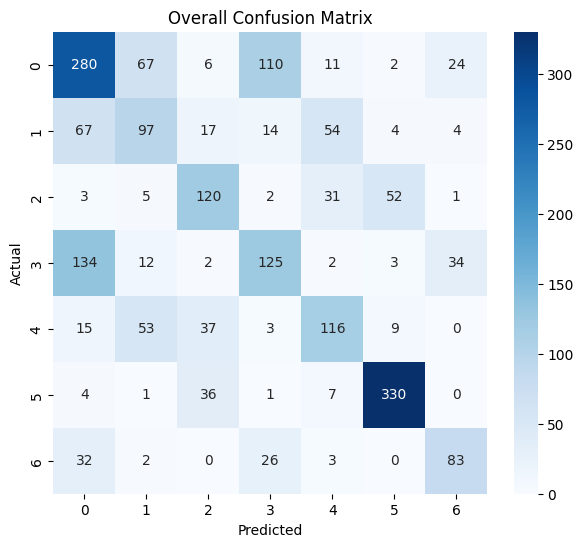

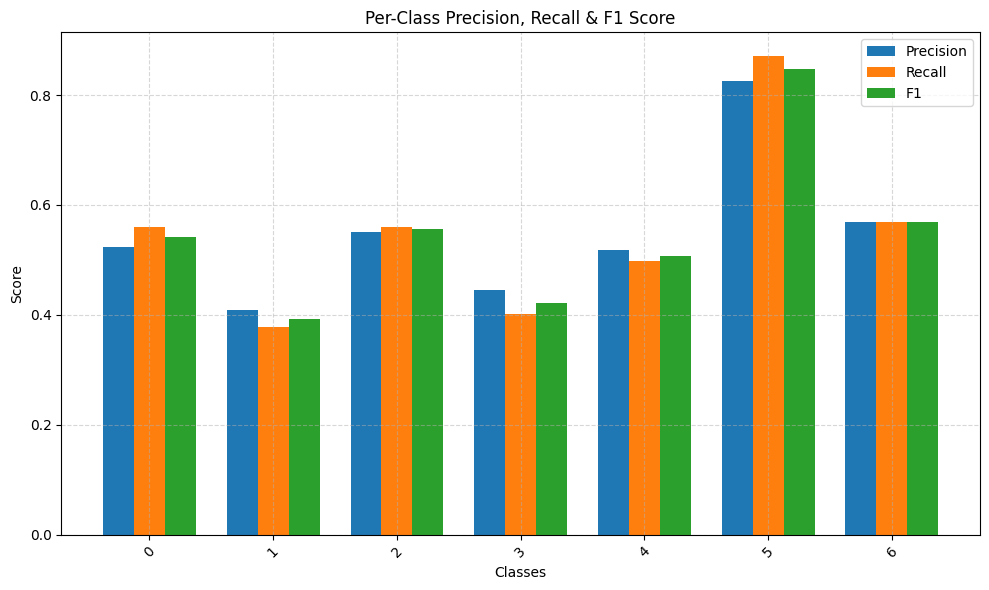

In [16]:
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    precision_recall_curve,
)

# ================================================================
# ADVANCED METRICS
# ================================================================

print("\n================== CLASSIFICATION REPORT ==================\n")
print(classification_report(all_labels_overall, all_preds_overall, target_names=full_dataset.classes))

# Confusion Matrix
cm = confusion_matrix(all_labels_overall, all_preds_overall)
plt.figure(figsize=(7,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=full_dataset.classes,
            yticklabels=full_dataset.classes)
plt.title("Overall Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.savefig("plots/final_confusion_matrix.png")
plt.show()

# ================================================================
# PER-CLASS PRECISION, RECALL, F1 BAR GRAPH
# ================================================================
report = classification_report(all_labels_overall, all_preds_overall, output_dict=True)

precision = [report[c]["precision"] for c in full_dataset.classes]
recall    = [report[c]["recall"] for c in full_dataset.classes]
f1        = [report[c]["f1-score"] for c in full_dataset.classes]

x = np.arange(len(full_dataset.classes))
width = 0.25

plt.figure(figsize=(10,6))
plt.bar(x - width, precision, width, label='Precision')
plt.bar(x, recall, width, label='Recall')
plt.bar(x + width, f1, width, label='F1')

plt.xlabel("Classes")
plt.ylabel("Score")
plt.title("Per-Class Precision, Recall & F1 Score")
plt.xticks(x, full_dataset.classes, rotation=45)
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.savefig("plots/per_class_scores.png")
plt.show()


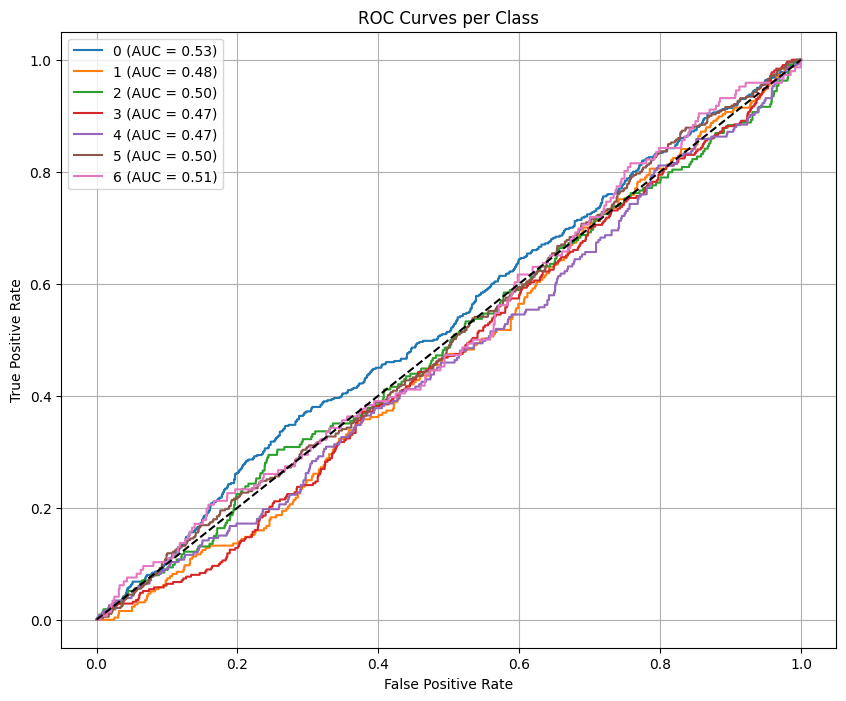

In [17]:
# Compute probabilities for ROC
y_true = np.array(all_labels_overall)
y_scores = []

model.eval()
with torch.no_grad():
    for imgs, labels in DataLoader(full_dataset, batch_size=32, shuffle=False):
        imgs = imgs.to(device)
        outputs = model(imgs)
        prob = torch.softmax(outputs, dim=1)
        y_scores.append(prob.cpu().numpy())

y_scores = np.vstack(y_scores)

plt.figure(figsize=(10,8))
for i, cls in enumerate(full_dataset.classes):
    fpr, tpr, _ = roc_curve(y_true == i, y_scores[:, i])
    auc = roc_auc_score(y_true == i, y_scores[:, i])
    plt.plot(fpr, tpr, label=f"{cls} (AUC = {auc:.2f})")

plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves per Class")
plt.legend()
plt.grid(True)
plt.savefig("plots/roc_curves.png")
plt.show()


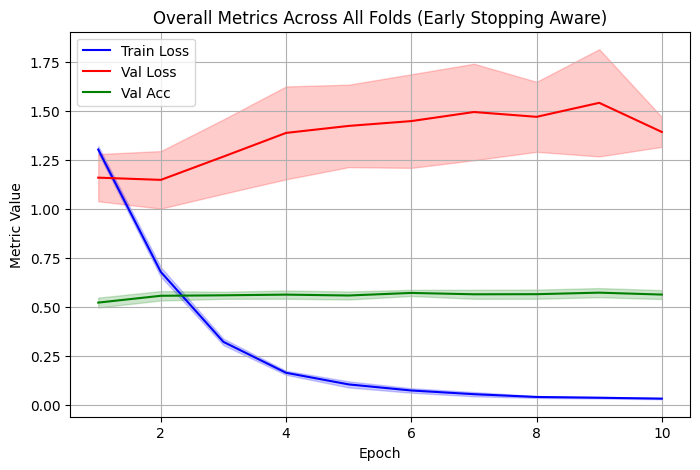

In [18]:
# ================================================================
# OVERALL METRICS ACROSS ALL FOLDS (PATCHED FOR EARLY STOPPING)
# ================================================================

# Find max epoch length across folds
max_len = max(len(h["train_loss"]) for h in all_histories)

def pad_list(lst, max_len):
    return lst + [np.nan] * (max_len - len(lst))

train_losses = np.array([pad_list(h["train_loss"], max_len) for h in all_histories])
val_losses = np.array([pad_list(h["val_loss"], max_len) for h in all_histories])
val_accs = np.array([pad_list(h["val_acc"], max_len) for h in all_histories])

epochs = list(range(1, max_len + 1))

# Means and STDs (ignore NaNs)
train_loss_mean = np.nanmean(train_losses, axis=0)
val_loss_mean   = np.nanmean(val_losses, axis=0)
val_acc_mean    = np.nanmean(val_accs, axis=0)

train_loss_std = np.nanstd(train_losses, axis=0)
val_loss_std   = np.nanstd(val_losses, axis=0)
val_acc_std    = np.nanstd(val_accs, axis=0)

plt.figure(figsize=(8,5))
plt.plot(epochs, train_loss_mean, label="Train Loss", color="blue")
plt.fill_between(epochs, train_loss_mean - train_loss_std, train_loss_mean + train_loss_std, alpha=0.2, color="blue")

plt.plot(epochs, val_loss_mean, label="Val Loss", color="red")
plt.fill_between(epochs, val_loss_mean - val_loss_std, val_loss_mean + val_loss_std, alpha=0.2, color="red")

plt.plot(epochs, val_acc_mean, label="Val Acc", color="green")
plt.fill_between(epochs, val_acc_mean - val_acc_std, val_acc_mean + val_acc_std, alpha=0.2, color="green")

plt.xlabel("Epoch")
plt.ylabel("Metric Value")
plt.title("Overall Metrics Across All Folds (Early Stopping Aware)")
plt.legend()
plt.grid(True)
plt.savefig("plots/overall_metrics_all_folds.png")
plt.show()


In [19]:
import torch
print("cuda available:", torch.cuda.is_available())
print("torch version:", torch.__version__)
!nvidia-smi


cuda available: True
torch version: 2.9.0+cu126
Fri Dec  5 13:52:39 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   73C    P0             32W /   70W |    3522MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
